In [10]:
import ifcopenshell, ifcopenshell.geom

In [11]:
ifc = ifcopenshell.open("../data/IfcOpenHouse_IFC4.ifc")

# Display House 

found technique in /pythonocc-demos/examples/ifc_clip_plane.py

In [12]:
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from OCC.Display.SimpleGui import init_display


# Specify to return pythonOCC shapes from ifcopenshell.geom.create_shape()
settings = ifcopenshell.geom.settings()
settings.set(settings.USE_PYTHON_OPENCASCADE, True)

display, start_display, add_menu, add_function_to_menu = init_display()

products = ifc.by_type("IfcProduct")
for product in products:
    if product.is_a("IfcOpeningElement"): continue
    if product.Representation:
        shape = ifcopenshell.geom.create_shape(settings, product)
        r, g, b, a = shape.styles[0] # the shape color
        color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)
        display_shape = display.DisplayShape(shape.geometry,color=color, transparency=abs(1 -a),update=True)

start_display() #must be used or kernel crashes

INFO:OCC.Display.backend:The qt-pyqt5 backend is already loaded...``load_backend`` can only be called once per session
INFO:OCC.Display.SimpleGui:GUI backend set to: qt-pyqt5
 ###### 3D rendering pipe initialisation #####
Display3d class initialization starting ...
Aspect_DisplayConnection created.
Graphic_Driver created.
V3d_Viewer created.
AIS_InteractiveContext created.
V3d_View created
Xw_Window created.
Display3d class successfully initialized.
 ########################################


qt.qpa.xcb: QXcbConnection: XCB error: 148 (Unknown), sequence: 741, resource id: 0, major code: 140 (Unknown), minor code: 20


# How can we control the camera?

found in /pythonocc-demos/examples/core_visualization_camera.py:

In [13]:
cam = display.View.Camera()  # type: Graphic3d_Camera

center = cam.Center()
eye = cam.Eye()
print(eye.XYZ().Coord())

eye.SetY(eye.Y() + 0.5)
cam.SetEye(eye)

#What is eye? What is center?

(17.970000267028805, -17.970000267028805, 16.7950005531311)


# Let's figure out where what this 'cam' is

In [14]:
import inspect
print(inspect.getmodule(cam))
print(type(cam))

<module 'OCC.Core.Graphic3d' from '/home/alon/LocalInstalls/miniconda3/envs/pyoccenv741/lib/python3.8/site-packages/OCC/Core/Graphic3d.py'>
<class 'OCC.Core.Graphic3d.Graphic3d_Camera'>


This module file is one step above 'swig' which interfaces between python and cpp code (occ,oce... pythonocc wraps them)

The class 'Graphic3d_Camera' inherits a-lot from swig

We can find things like this:</br> 
   Center = _swig_new_instance_method(_Graphic3d.Graphic3d_Camera_Center)</br>
    ConvertProj2View = _swig_new_instance_method(_Graphic3d.Graphic3d_Camera_ConvertProj2View) </br>
    ConvertView2Proj = _swig_new_instance_method(_Graphic3d.Graphic3d_Camera_ConvertView2Proj)</br>
    ConvertView2World = _swig_new_instance_method(_Graphic3d.Graphic3d_Camera_ConvertView2World)</br>
    ConvertWorld2View = _swig_new_instance_method(_Graphic3d.Graphic3d_Camera_ConvertWorld2View)</br>

# Not so useful... we need reading material
lucky, we found this https://github.com/tpaviot/pythonocc-core/issues/860 </br>
which points to this https://dev.opencascade.org/doc/occt-7.4.0/overview/html/occt_user_guides__visualization.html#occt_visu_4_3 </br>
I also found this https://dev.opencascade.org/doc/refman/html/class_graphic3d___camera.html

There it is said: </br>
Eye – defines the observer (camera) position. Make sure the Eye point never gets between the Front and Back clipping planes. </br>
Center – defines the origin of View Reference Coordinates (where camera is aimed at). </br>
Direction – defines the direction of camera view (from the Eye to the Center). </br>
Distance – defines the distance between the Eye and the Center. </br>
Front Plane – defines the position of the front clipping plane in View Reference Coordinates system. </br>
Back Plane – defines the position of the back clipping plane in View Reference Coordinates system. </br>
ZNear – defines the distance between the Eye and the Front plane. </br>
ZFar – defines the distance between the Eye and the Back plane. </br>

In [15]:
print('cam.Znear() = {}'.format(cam.ZNear()))
print('cam.ZFar() = {}'.format(cam.ZFar()))
print('cam.Center().XYZ().Coord() = {}'.format(cam.Center().XYZ().Coord()))
print('cam.Distance() = {}'.format(cam.Distance()))
print('cam.Eye().XYZ().Coord() = {}'.format(cam.Eye().XYZ().Coord()))
print('cam.FOVy() = {}'.format(cam.FOVy())) #FOVx doesnt exist. documentation says its automatically computed by aspect ratio
print('cam.Up().Coord() = {}'.format(cam.Up().Coord()))
print('cam.OrientationMatrix().GetData = {}'.format(cam.OrientationMatrix().GetData()))
print('cam.Aspect = {}'.format(cam.Aspect()))

cam.Znear() = 2.720616996294467
cam.ZFar() = 59.529293529024585
cam.Center().XYZ().Coord() = (0.0, 0.0, -1.174999713897705)
cam.Distance() = 30.838980666098827
cam.Eye().XYZ().Coord() = (17.970000267028805, -17.470000267028805, 16.7950005531311)
cam.FOVy() = 45.0
cam.Up().Coord() = (-0.408248290463863, 0.408248290463863, 0.816496580927726)
cam.OrientationMatrix().GetData = <Swig Object of type 'double *' at 0x7fe7d40c8450>
cam.Aspect = 1.3333333333333333


Looks like its all roses until we try and get what we really need... what is this swig stuff again. </br>

prehaps this hold some information: https://stackoverflow.com/questions/51776809/read-swig-python-double-object-into-numpy-maybe-through-ctypes

In [16]:

data = cam.OrientationMatrix().GetData()
print('output of GetData():')
print(data, end = '\n\n')
v = list((c_double * 16).from_address(int(data)))
M = np.array(v).reshape((4,4))
R_c2w = M[0:3,0:3]
t_w_c2w = M[3,0:3]
t_w_w2c = R_c2w @ (-t_w_c2w)


output of GetData():
<Swig Object of type 'double *' at 0x7fe7d8b09900>



In [17]:
import numpy as np
from ctypes import c_double
from ctypes import c_float

data = cam.OrientationMatrix().GetData()
print('output of GetData():')
print(data, end = '\n\n')
v = list((c_double * 16).from_address(int(data)))
M = np.array(v).reshape((4,4)).T
print('after conversion, M = ')
print(M,end = '\n\n')

R_w2c = M[0:3,0:3]
R_c2w = R_w2c.T
t_c_c2w = M[0:3,3]

t_w_w2c = R_c2w @ (-t_c_c2w)
print("Camera's eye location calcualted from matrix:")
print(t_w_w2c)
print("Camera's eye location from object:")
print(cam.Eye().XYZ().Coord())

output of GetData():
<Swig Object of type 'double *' at 0x7fe7d40c89f0>

after conversion, M = 
[[ 7.00441133e-01  7.13679484e-01 -6.61917523e-03 -7.77752900e-03]
 [-4.12114254e-01  4.12006936e-01  8.12657447e-01  9.54872268e-01]
 [ 5.82704093e-01 -5.66490847e-01  5.82704093e-01 -3.01543035e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera's eye location calcualted from matrix:
[ 17.97000027 -17.47000027  16.79500055]
Camera's eye location from object:
(17.970000267028805, -17.470000267028805, 16.7950005531311)


## Before we can make some pretty pictures, we need to play with "the constructs"

In [18]:
#Make a Transform

from OCC.Core import gp

def gpMat3toNumpy(gpMat3):
    #gp_mat class is a 3x3 matrix class with no method to return values
    #notice how the Row method accepts integers starting 1
    row0 = gpMat3.Row(1).Coord()
    row1 = gpMat3.Row(2).Coord()
    row2 = gpMat3.Row(3).Coord()
    M = np.array([row0,
            row1,
            row2])
    return M

#Lets Test it:
gpT = gp.gp_Trsf() #initalize unit transform
gpR = gpT.GetRotation().GetMatrix() #getRotation returns a quaternion representation
npR = gpMat3toNumpy(gpR)
print(npR)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [19]:
#Edit a Transform
p = gp.gp_Pnt(0,0,1)
v = gp.gp_Dir(0,0,1)
ax1 = gp.gp_Ax1(p,v)

gpT.SetRotation(ax1,np.pi/2)
gpR = gpT.GetRotation().GetMatrix() #getRotation returns a quaternion representation
npR = gpMat3toNumpy(gpR)
print(npR)

[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]


In [20]:
def vNtheta2Quat(v,theta):
    #builds quaternion for rotation around vector v
    #v - unit direction vector
    #theta - angle in radians
    qx = v[0] * np.sin(theta/2)
    qy = v[1] * np.sin(theta/2)
    qz = v[2] * np.sin(theta/2)
    qw = np.cos(theta/2)
    return (qx,qy,qz,qw)

def makeTrsf(v,theta,t):
    #builds transform such that the vector representation V_O1 will become VO2:
    #V_O2 = T*V_O1
    
    #This transform was made to change coordinate systems as oppose to evolving a state
    #NOT THIS: X_k+1 = T*X_k

    #v - unit direction vector
    #theta - angle in radians with which to rotate O1 until it has the same orientation as O2
    #t translation in O1 coordinates to O2

    gpT = gp.gp_Trsf() #initalize unit transform
    q = vNtheta2Quat(v,-theta)
    gpq = gp.gp_Quaternion(q[0],q[1],q[2],q[3])
    gpT.SetRotation(gpq)

    R = gpMat3toNumpy(gpq.GetMatrix())
    t = -R @ np.array(t)
    gpT.SetTranslationPart(gp.gp_Vec(t[0],t[1],t[2]))
    return gpT
    

#Some Testing
T = makeTrsf(v = (0,0,1), theta = np.pi/4, t = (0, 5, 0))
T.Invert() #we want to evolve, not to convert coordiante system
print(gpMat3toNumpy(T.GetRotation().GetMatrix()))
print(T.TranslationPart().Coord())

[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
(-0.0, 5.0, -0.0)


Wow that was exhusting.. we need to build a proper numpy wrapper for this

# Alright lets set up some pretty pictures

IFC-Demos/ref-gits/pythonocc-demos/examples/...</br>
core_offscreen_rendering.py </br>
core_display_export_to_image.py </br>


found useful:
https://github.com/tpaviot/pythonocc-core/issues/526 </br>
https://github.com/tpaviot/pythonocc-core/issues/976

In [21]:
from OCC.Display.OCCViewer import Viewer3d
offscreen_renderer = Viewer3d()
offscreen_renderer.Create()
offscreen_renderer.SetModeShaded()

products = ifc.by_type("IfcProduct")
for product in products:
    if product.is_a("IfcOpeningElement"): continue
    if product.Representation:
        shape = ifcopenshell.geom.create_shape(settings, product)
        r, g, b, a = shape.styles[0] # the shape color
        color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)
        display_shape = offscreen_renderer.DisplayShape(shape.geometry,color=color, transparency=abs(1 -a),update=True)

 ###### 3D rendering pipe initialisation #####
Display3d class initialization starting ...
Aspect_DisplayConnection created.
Graphic_Driver created.
V3d_Viewer created.
AIS_InteractiveContext created.
V3d_View created
Display3d class successfully initialized.
 ########################################


In [22]:
T = makeTrsf(v = (1,0,0), theta = -np.pi/4, t =(5,5,10))
T.Invert() #again.. we want to evolve

cam = offscreen_renderer.View.Camera()
cam.Transform(T)

from OCC.Core.Graphic3d import Graphic3d_Camera
cam.SetProjectionType(Graphic3d_Camera.Projection_Perspective)

offscreen_renderer.View.Dump('./capture_jpeg.jpeg')

True

In [23]:
from OCC.Core.Graphic3d import Graphic3d_BufferType
# export to a 640*480 image data
data_640_480 = offscreen_renderer.GetImageData(640, 480, Graphic3d_BufferType.Graphic3d_BT_RGB) #There is also: Graphic3d_BT_Depth!

# the same image to 1024*768
data_1024_768 = offscreen_renderer.GetImageData(1024, 768, Graphic3d_BufferType.Graphic3d_BT_RGB)

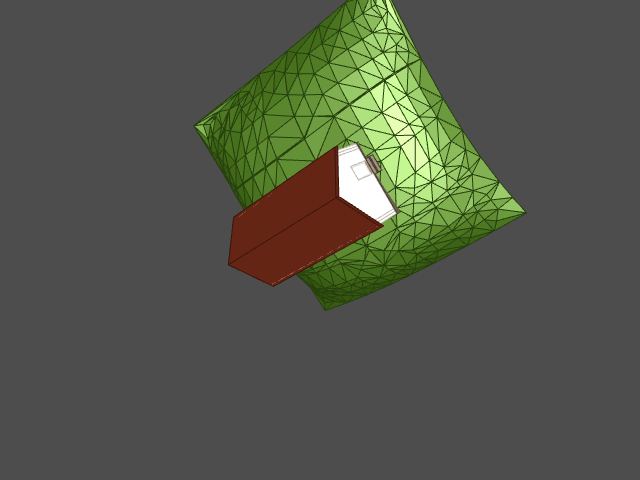

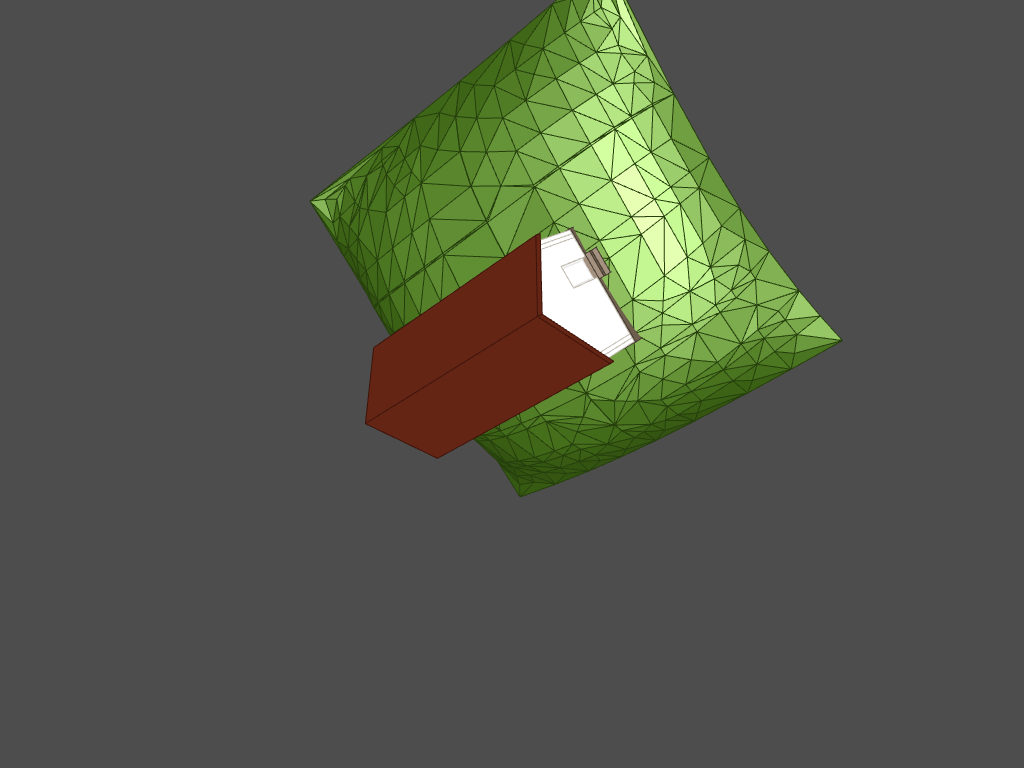

In [24]:
from PIL import Image
from IPython.display import display

img = Image.frombytes('RGB', (640, 480), data_640_480)
display(img)

img = Image.frombytes('RGB', (1024, 768), data_1024_768)
display(img)